In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import src.ksdagg as src_ksdagg
import experiments.kef as exp_kef
import experiments.efm as exp_efm
import experiments.rbm as exp_rbm

In [157]:
n = 100
dim = 50
res_stats = pickle.load(open(f"../data/bw/stats_n{n}_d{dim}.pkl", "rb"))

bw_ls = list(res_stats.keys())
print(bw_ls)
ol_ls = list(res_stats[bw_ls[0]].keys())
print(ol_ls)
eps_ls = list(res_stats[bw_ls[0]][ol_ls[0]].keys())
eps_ls

['med', 0.01, 0.1, 1.0, 10.0, 100.0]
[0.0, 1.0, 10.0, 100.0]


[0.05]

In [147]:
methods = {"standard": "IMQ"}

plot_df = {"eps": [], "method": [], "rej": [], "bw": [], "bw_order": []}
    
for bw in bw_ls[1:]:
    for eps in eps_ls:
        for m, m_label in methods.items():
            rr = res_stats[bw][eps][m]
            # plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
            plot_df["bw"].extend([bw] * len(rr["nonsq_stat"]))
            plot_df["bw_order"].extend([np.round(np.log(bw) / np.log(10.), 2)] * len(rr["rej"]))

plot_df = pd.DataFrame(plot_df)

# med heuristic
med_plot_df = {"eps": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_stats["med"][eps]["standard"]
    med_plot_df["eps"].extend([eps] * len(rr["rej"]))
    
    med_plot_df["rej"].extend(rr["rej"])
    med_plot_df["method"].extend(["med"] * len(rr["rej"]))

med_plot_df = pd.DataFrame(med_plot_df)

# ksdagg
ksdagg_plot_df = {"eps": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_stats[bw_ls[0]][eps]["ksdagg"]
    ksdagg_plot_df["eps"].extend([eps] * len(rr["rej"]))
    
    ksdagg_plot_df["rej"].extend(rr["rej"])
    ksdagg_plot_df["method"].extend(["KSDAgg"] * len(rr["rej"]))

ksdagg_plot_df = pd.DataFrame(ksdagg_plot_df)

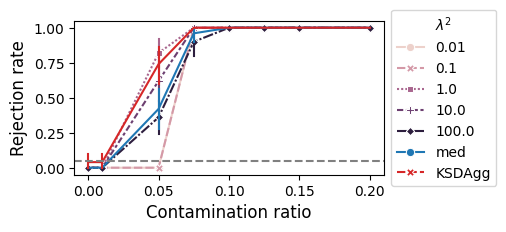

In [154]:
# _, axes = plt.subplots(ncols=len(eps0_ls), figsize=(3*len(eps0_ls), 2))
_, ax = plt.subplots(figsize=(4, 2))

g1 = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="bw_order", style="bw_order", markers=True, err_style="bars")
lines = ax.get_lines()
line_colors = [line.get_color() for line in lines]
g2 = sns.lineplot(ax=ax, data=med_plot_df, x="eps", y="rej", markers=True, err_style="bars", color="C0")
g3 = sns.lineplot(ax=ax, data=ksdagg_plot_df, x="eps", y="rej", markers=True, err_style="bars", color="C3")
# ax.axvline(eps0, color="k", linestyle="-.", label=r"$\epsilon_0$")
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.set_xlabel("Contamination ratio", fontsize=12)
ax.set_ylabel("Rejection rate", fontsize=12)

lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=bw_ls[1:]+["med", "KSDAgg"], title=r"$\lambda^2$")
lg.get_lines()[-2].set_color("C0")
lg.get_lines()[-1].set_color("C3")

plt.savefig("../figs/robust/bw.pdf", bbox_extra_artists=(lg,), bbox_inches="tight")

In [116]:
X_res = pickle.load(open(f"../data/bw/X_res_n{n}_d{dim}.pkl", "rb"))

In [130]:
X = X_res[eps_ls[6]][0]
kernel = kernels.RBF(med_heuristic=True, X=X, Y=X)
kernel.sigma_sq / 2.

Array(53.353546, dtype=float32)

# vs. outlier

In [141]:
n = 100
dim = 50
res_stats = pickle.load(open(f"../data/bw/ol_stats_n{n}_d{dim}.pkl", "rb"))

bw_ls = list(res_stats.keys())
print(bw_ls)
ol_ls = list(res_stats[bw_ls[0]].keys())
print(ol_ls)
eps_ls = list(res_stats[bw_ls[0]][ol_ls[0]].keys())
eps_ls

['med', 0.01, 0.1, 1.0, 10.0, 100.0]
[0.1, 1.0, 10.0, 25.0, 50.0, 100.0]


[0.05]

In [142]:
methods = {"standard": "IMQ"}
eps = eps_ls[0]

plot_df = {"ol": [], "method": [], "rej": [], "bw": [], "bw_order": []}
    
for bw in bw_ls[1:]:
    for ol in ol_ls:
        for m, m_label in methods.items():
            rr = res_stats[bw][ol][eps][m]
            # plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["ol"].extend([ol] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
            plot_df["bw"].extend([bw] * len(rr["nonsq_stat"]))
            plot_df["bw_order"].extend([np.round(np.log(bw) / np.log(10.), 2)] * len(rr["rej"]))

plot_df = pd.DataFrame(plot_df)

# med heuristic
med_plot_df = {"ol": [], "method": [], "rej": []}
for ol in ol_ls:
    rr = res_stats["med"][ol][eps]["standard"]
    med_plot_df["ol"].extend([ol] * len(rr["rej"]))
    
    med_plot_df["rej"].extend(rr["rej"])
    med_plot_df["method"].extend(["med"] * len(rr["rej"]))

med_plot_df = pd.DataFrame(med_plot_df)

# ksdagg
ksdagg_plot_df = {"ol": [], "method": [], "rej": []}
for ol in ol_ls:
    rr = res_stats[bw_ls[0]][ol][eps]["ksdagg"]
    ksdagg_plot_df["ol"].extend([ol] * len(rr["rej"]))
    
    ksdagg_plot_df["rej"].extend(rr["rej"])
    ksdagg_plot_df["method"].extend(["KSDAgg"] * len(rr["rej"]))

ksdagg_plot_df = pd.DataFrame(ksdagg_plot_df)

In [143]:
rr = res_stats[bw_ls[0]][100.][eps]["ksdagg"]
rr["summary"][4]["Single test 3"]

{'Reject': Array(True, dtype=bool),
 'Kernel IMQ': True,
 'Bandwidth': Array(1.4142135, dtype=float32),
 'KSD': Array(20.261799, dtype=float32),
 'KSD quantile': Array(20.23774, dtype=float32),
 'p-value': Array(0.02298851, dtype=float32),
 'p-value threshold': Array(0.05597201, dtype=float32)}

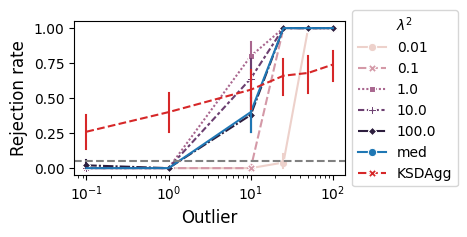

In [147]:
# _, axes = plt.subplots(ncols=len(eps0_ls), figsize=(3*len(eps0_ls), 2))
_, ax = plt.subplots(figsize=(3.5, 2))

g1 = sns.lineplot(ax=ax, data=plot_df, x="ol", y="rej", hue="bw_order", style="bw_order", markers=True, err_style="bars")
g2 = sns.lineplot(ax=ax, data=med_plot_df, x="ol", y="rej", markers=True, err_style="bars", color="C0")
g3 = sns.lineplot(ax=ax, data=ksdagg_plot_df, x="ol", y="rej", markers=True, err_style="bars", color="C3", linestyle="--")
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.set_xlabel("Outlier", fontsize=12)
ax.set_ylabel("Rejection rate", fontsize=12)
ax.set_xscale("log")

lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=bw_ls[1:]+["med", "KSDAgg"], title=r"$\lambda^2$")
lg.get_lines()[-2].set_color("C0")
lg.get_lines()[-1].set_color("C3")

# plt.savefig("../figs/robust/bw.pdf", bbox_extra_artists=(lg,), bbox_inches="tight")